# **Stable Video Infinity for Image to Video Generation**

- If you are not using the T4, no additional settings need to be changed. Simply upload your image and enter your prompts. I haven’t tested with `offload_models_for_lowMemory` enabled, but if using the A100 or H100 GPU, you should be able to disable `offload_models_for_lowMemory` in the Prepare Environment section for faster generation.

- If using the T4, you can generate 5-second 480p video segments (81 frames at 16 fps) with the Q4_K_M GGUF model. By adding a prompt to all 12 prompt fields, 12 video segments will be generated and joined to produce a video of up to one minute. Make sure to disable `use_sage_attention` in the Generate Video section, as Torch versions above 2.6 may crash on the T4 when sageattention is enabled. Also disable `use_preferred_wanModels` in the Prepare Environment section, since the current links point to ~15 GB safetensors models, which will likely result in crashes on the T4.

- All generated last frames are saved in content/ComfyUI/output and all generated videos are saved in content/ComfyUI/output/video.

- Github project page: https://github.com/vita-epfl/Stable-Video-Infinity

- Models sources: (1) https://huggingface.co/Kijai/WanVideo_comfy_fp8_scaled/tree/main/I2V (2) https://huggingface.co/Kijai/WanVideo_comfy/tree/main/LoRAs/Stable-Video-Infinity/v2.0 (3) https://huggingface.co/lightx2v/Wan2.2-Distill-Loras/tree/main
- Notebook source: https://github.com/Isi-dev/Google-Colab_Notebooks
- Premium notebooks: https://isinse.gumroad.com/
- Free Web apps: https://isi-dev.netlify.app/#/isiapps#home

In [ ]:
# @title {"single-column":true}

# default links

# high_noise_model_download_url = "https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_high_noise_14B_Q4_K_M.gguf"
# low_noise_model_download_url = "https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_low_noise_14B_Q4_K_M.gguf"
# high_noise_speed_LoRA_download_url = "https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/lightx2v_I2V_14B_480p_cfg_step_distill_rank32_bf16.safetensors"
# low_noise_speed_LoRA_download_url = "https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/lightx2v_I2V_14B_480p_cfg_step_distill_rank32_bf16.safetensors"



# @markdown # 💥1. Prepare Environment

# !pip install torch==2.6.0 torchvision==0.21.0
# !pip install torch==2.8.0 torchvision==0.23.0
!pip install torch torchvision torchaudio
%cd /content
from IPython.display import clear_output
# !pip install -q torchsde einops diffusers accelerate xformers==0.0.29.post2 triton==3.2.0 sageattention==1.0.6
# !pip install -q torchsde einops diffusers accelerate xformers==0.0.32.post1 triton==3.4 sageattention==1.0.6
!pip install -q torchsde einops diffusers accelerate sageattention==1.0.6

!pip install av spandrel albumentations onnx opencv-python onnxruntime
!git clone  --branch ComfyUI_22_01_2026_v0.10.0 https://github.com/Isi-dev/ComfyUI.git
!pip install -r /content/ComfyUI/requirements.txt
clear_output()
!pip install av spandrel albumentations insightface onnx opencv-python segment_anything ultralytics onnxruntime
clear_output()
!pip install onnxruntime-gpu -y

clear_output()
%cd /content/ComfyUI/custom_nodes
import subprocess
!git clone --branch kj_1.2.6 https://github.com/Isi-dev/ComfyUI_KJNodes
!git clone --branch ComfyUI_GGUF_22_01_2026 https://github.com/Isi-dev/ComfyUI_GGUF.git

%cd /content/ComfyUI/custom_nodes/ComfyUI_KJNodes
!pip install -r requirements.txt
%cd /content/ComfyUI/custom_nodes/ComfyUI_GGUF
!pip install -r requirements.txt
clear_output()

%cd /content
!git clone https://github.com/Isi-dev/Practical-RIFE
%cd /content/Practical-RIFE
!pip install git+https://github.com/rk-exxec/scikit-video.git@numpy_deprecation
!mkdir -p /content/Practical-RIFE/train_log
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/IFNet_HDv3.py -O /content/Practical-RIFE/train_log/IFNet_HDv3.py
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/RIFE_HDv3.py -O /content/Practical-RIFE/train_log/RIFE_HDv3.py
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/refine.py -O /content/Practical-RIFE/train_log/refine.py
!wget -q https://huggingface.co/Isi99999/Frame_Interpolation_Models/resolve/main/4.25/train_log/flownet.pkl -O /content/Practical-RIFE/train_log/flownet.pkl
clear_output()


%cd /content/ComfyUI
!apt -y install -qq aria2 ffmpeg
clear_output()


import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import sys
from pathlib import Path
import random
from typing import Sequence, Mapping, Any, Union
import torch

import numpy as np
import cv2
from PIL import Image
import gc
import imageio
import shutil
from google.colab import files
from IPython.display import display, HTML, Image as IPImage
sys.path.insert(0, '/content/ComfyUI')

from nodes import NODE_CLASS_MAPPINGS

from custom_nodes.ComfyUI_KJNodes.nodes.model_optimization_nodes import (
    PathchSageAttentionKJ,
    WanVideoNAG,
    SkipLayerGuidanceWanVideo
)

def download_with_aria2c(link, folder="/content/ComfyUI/models/loras"):
    import os

    filename = link.split("/")[-1]
    command = f"aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {link} -d {folder} -o {filename}"

    print("Executing download command:")
    print(command)

    os.makedirs(folder, exist_ok=True)
    get_ipython().system(command)

    return filename



def download_civitai_model(civitai_link, civitai_token, folder="/content/ComfyUI/models/loras"):
    import os
    import time

    os.makedirs(folder, exist_ok=True)

    try:
        model_id = civitai_link.split("/models/")[1].split("?")[0]
    except IndexError:
        raise ValueError("Invalid Civitai URL format. Please use a link like: https://civitai.com/api/download/models/1523247?...")

    civitai_url = f"https://civitai.com/api/download/models/{model_id}?type=Model&format=SafeTensor"
    if civitai_token:
        civitai_url += f"&token={civitai_token}"

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"model_{timestamp}.safetensors"

    full_path = os.path.join(folder, filename)

    download_command = f"wget --max-redirect=10 --show-progress \"{civitai_url}\" -O \"{full_path}\""
    print("Downloading from Civitai...")

    os.system(download_command)

    local_path = os.path.join(folder, filename)
    if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
        print(f"LoRA downloaded successfully: {local_path}")
    else:
        print(f"❌ LoRA download failed or file is empty: {local_path}")

    return filename

def download_lora(link, folder="/content/ComfyUI/models/loras", civitai_token=None):
    """
    Download a model file, automatically detecting if it's a Civitai link or huggingface download.

    Args:
        link: The download URL (either huggingface or Civitai)
        folder: Destination folder for the download
        civitai_token: Optional token for Civitai downloads (required if link is from Civitai)

    Returns:
        The filename of the downloaded model
    """
    if "civitai.com" in link.lower():
        if not civitai_token:
            raise ValueError("Civitai token is required for Civitai downloads")
        return download_civitai_model(link, civitai_token, folder)
    else:
        return download_with_aria2c(link, folder)



def model_download(url: str, dest_dir: str, filename: str = None, silent: bool = True) -> bool:
    """
    Colab-optimized download with aria2c

    Args:
        url: Download URL
        dest_dir: Target directory (will be created if needed)
        filename: Optional output filename (defaults to URL filename)
        silent: If True, suppresses all output (except errors)

    Returns:
        bool: True if successful, False if failed
    """
    try:
        # Create destination directory
        Path(dest_dir).mkdir(parents=True, exist_ok=True)

        # Set filename if not specified
        if filename is None:
            filename = url.split('/')[-1].split('?')[0]  # Remove URL parameters

        # Build command
        cmd = [
            'aria2c',
            '--console-log-level=error',
            '-c', '-x', '16', '-s', '16', '-k', '1M',
            '-d', dest_dir,
            '-o', filename,
            url
        ]

        # Add silent flags if requested
        if silent:
            cmd.extend(['--summary-interval=0', '--quiet'])
            print(f"Downloading {filename}...", end=' ', flush=True)

        # Run download
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)

        if silent:
            print("Done!")
        else:
            print(f"Downloaded {filename} to {dest_dir}")
        return filename

    except subprocess.CalledProcessError as e:
        error = e.stderr.strip() or "Unknown error"
        print(f"\nError downloading {filename}: {error}")
        return False
    except Exception as e:
        print(f"\nError: {str(e)}")
        return False


def get_value_at_index(obj: Union[Sequence, Mapping], index: int) -> Any:
    """Returns the value at the given index of a sequence or mapping.

    If the object is a sequence (like list or string), returns the value at the given index.
    If the object is a mapping (like a dictionary), returns the value at the index-th key.

    Some return a dictionary, in these cases, we look for the "results" key

    Args:
        obj (Union[Sequence, Mapping]): The object to retrieve the value from.
        index (int): The index of the value to retrieve.

    Returns:
        Any: The value at the given index.

    Raises:
        IndexError: If the index is out of bounds for the object and the object is not a mapping.
    """
    try:
        return obj[index]
    except KeyError:
        return obj["result"][index]

def find_path(name: str, path: str = None) -> str:
    """
    Recursively looks at parent folders starting from the given path until it finds the given name.
    Returns the path as a Path object if found, or None otherwise.
    """
    # If no path is given, use the current working directory
    if path is None:
        path = os.getcwd()

    # Check if the current directory contains the name
    if name in os.listdir(path):
        path_name = os.path.join(path, name)
        print(f"{name} found: {path_name}")
        return path_name

    # Get the parent directory
    parent_directory = os.path.dirname(path)

    # If the parent directory is the same as the current directory, we've reached the root and stop the search
    if parent_directory == path:
        return None

    # Recursively call the function with the parent directory
    return find_path(name, parent_directory)

def add_comfyui_directory_to_sys_path() -> None:
    """
    Add 'ComfyUI' to the sys.path
    """
    comfyui_path = find_path("ComfyUI")
    if comfyui_path is not None and os.path.isdir(comfyui_path):
        sys.path.append(comfyui_path)
        print(f"'{comfyui_path}' added to sys.path")

def add_extra_model_paths() -> None:
    """
    Parse the optional extra_model_paths.yaml file and add the parsed paths to the sys.path.
    """
    try:
        from main import load_extra_path_config
    except ImportError:
        print(
            "Could not import load_extra_path_config from main.py. Looking in utils.extra_config instead."
        )
        from utils.extra_config import load_extra_path_config

    extra_model_paths = find_path("extra_model_paths.yaml")

    if extra_model_paths is not None:
        load_extra_path_config(extra_model_paths)
    else:
        print("Could not find the extra_model_paths config file.")

# add_extra_model_paths()

import asyncio
import nest_asyncio

def import_custom_nodes() -> None:
    """Load all built-in and external custom nodes in a Jupyter/Colab-safe way."""

    from nodes import init_builtin_extra_nodes, init_external_custom_nodes

    async def loader():
        # Load built-in extra nodes
        import_failed = await init_builtin_extra_nodes()

        # Load external custom nodes
        await init_external_custom_nodes()

        if import_failed:
            print("WARNING: Some comfy_extras nodes failed to import:")
            for node in import_failed:
                print(" -", node)

    try:
        # Try running normally (works in scripts)
        asyncio.run(loader())
    except RuntimeError:
        # Already inside an event loop → Jupyter/Colab
        nest_asyncio.apply()
        loop = asyncio.get_event_loop()
        return loop.run_until_complete(loader())

# @markdown ### Models to download
model_quant = "Q4_K_M" # @param ["Q4_K_M", "Q5_K_M", "Q6_K", "Q8_0"]

use_preferred_wanModels = True # @param {type:"boolean"}
high_noise_model_download_url = "https://huggingface.co/Kijai/WanVideo_comfy_fp8_scaled/resolve/main/I2V/Wan2_2-I2V-A14B-HIGH_fp8_e4m3fn_scaled_KJ.safetensors"# @param {"type":"string"}
low_noise_model_download_url = "https://huggingface.co/Kijai/WanVideo_comfy_fp8_scaled/resolve/main/I2V/Wan2_2-I2V-A14B-LOW_fp8_e4m3fn_scaled_KJ.safetensors"# @param {"type":"string"}

# @markdown ### Speedup LoRAs to download
use_preferred_speedup_LoRAs = True # @param {type:"boolean"}
download_high_noise_speed_LoRA = True # @param {type:"boolean"}
high_noise_speed_LoRA_download_url = "https://huggingface.co/lightx2v/Wan2.2-Distill-Loras/resolve/main/wan2.2_i2v_A14b_high_noise_lora_rank64_lightx2v_4step_1022.safetensors"# @param {"type":"string"}
download_low_noise_speed_LoRA = True # @param {type:"boolean"}
low_noise_speed_LoRA_download_url = "https://huggingface.co/lightx2v/Wan2.2-Distill-Loras/resolve/main/wan2.2_i2v_A14b_low_noise_lora_rank64_lightx2v_4step_1022.safetensors"# @param {"type":"string"}

# lightx2v_rank = "128" # @param ["32", "64", "128"]


# @markdown ### Other LoRAs to download
download_loRA_1 = True # @param {type:"boolean"}
lora_1_download_url = "https://huggingface.co/Kijai/WanVideo_comfy/resolve/main/LoRAs/Stable-Video-Infinity/v2.0/SVI_v2_PRO_Wan2.2-I2V-A14B_HIGH_lora_rank_128_fp16.safetensors"# @param {"type":"string"}
download_loRA_1_for_lowNoise = True # @param {type:"boolean"}
lora_1_download_url_for_lowNoise = "https://huggingface.co/Kijai/WanVideo_comfy/resolve/main/LoRAs/Stable-Video-Infinity/v2.0/SVI_v2_PRO_Wan2.2-I2V-A14B_LOW_lora_rank_128_fp16.safetensors"# @param {"type":"string"}

download_loRA_2 = False # @param {type:"boolean"}
lora_2_download_url = "Put your loRA here"# @param {"type":"string"}
download_loRA_2_for_lowNoise = False # @param {type:"boolean"}
lora_2_download_url_for_lowNoise = "Put your low noise loRA here"# @param {"type":"string"}

download_loRA_3 = False # @param {type:"boolean"}
lora_3_download_url = "https://huggingface.co/Remade-AI/Rotate/resolve/main/rotate_20_epochs.safetensors"# @param {"type":"string"}
download_loRA_3_for_lowNoise = False # @param {type:"boolean"}
lora_3_download_url_for_lowNoise = "https://huggingface.co/Remade-AI/Rotate/resolve/main/rotate_20_epochs.safetensors"# @param {"type":"string"}

token_if_civitai_url = "Put your civitai token here"# @param {"type":"string"}

lora_1 = None
if download_loRA_1:
    lora_1 = download_lora(lora_1_download_url, civitai_token=token_if_civitai_url)
# Validate loRA file extension
valid_extensions = {'.safetensors', '.ckpt', '.pt', '.pth', '.sft'}
if lora_1:
    if not any(lora_1.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_1}")
        lora_1 = None
    else:
        clear_output()
        print("loRA 1 downloaded succesfully!")

lora_1_lowNoise = None
if download_loRA_1_for_lowNoise:
    lora_1_lowNoise = download_lora(lora_1_download_url_for_lowNoise, civitai_token=token_if_civitai_url)
if lora_1_lowNoise:
    if not any(lora_1_lowNoise.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_1_lowNoise}")
        lora_1_lowNoise = None
    else:
        clear_output()
        print("loRA 1_lowNoise downloaded succesfully!")

lora_2 = None
if download_loRA_2:
    lora_2 = download_lora(lora_2_download_url, civitai_token=token_if_civitai_url)
if lora_2:
    if not any(lora_2.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_2}")
        lora_2 = None
    else:
        clear_output()
        print("loRA 2 downloaded succesfully!")

lora_2_lowNoise = None
if download_loRA_2_for_lowNoise:
    lora_2_lowNoise = download_lora(lora_2_download_url_for_lowNoise, civitai_token=token_if_civitai_url)
if lora_2_lowNoise:
    if not any(lora_2_lowNoise.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_2_lowNoise}")
        lora_2_lowNoise = None
    else:
        clear_output()
        print("loRA 2_lowNoise downloaded succesfully!")

lora_3 = None
if download_loRA_3:
    lora_3 = download_lora(lora_3_download_url, civitai_token=token_if_civitai_url)
if lora_3:
    if not any(lora_3.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_3}")
        lora_3 = None
    else:
        clear_output()
        print("loRA 3 downloaded succesfully!")

lora_3_lowNoise = None
if download_loRA_3_for_lowNoise:
    lora_3_lowNoise = download_lora(lora_3_download_url_for_lowNoise, civitai_token=token_if_civitai_url)
if lora_3_lowNoise:
    if not any(lora_3_lowNoise.lower().endswith(ext) for ext in valid_extensions):
        print(f"❌ Invalid LoRA format: {lora_3_lowNoise}")
        lora_3_lowNoise = None
    else:
        clear_output()
        print("loRA 3_lowNoise downloaded succesfully!")



if use_preferred_wanModels:
    high_model = model_download(high_noise_model_download_url, "/content/ComfyUI/models/diffusion_models")
    low_model = model_download(low_noise_model_download_url, "/content/ComfyUI/models/diffusion_models")
else:
    if model_quant == "Q4_K_M":
        high_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_high_noise_14B_Q4_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
        low_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_low_noise_14B_Q4_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
    elif model_quant == "Q5_K_M":
        high_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_high_noise_14B_Q5_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
        low_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_low_noise_14B_Q5_K_M.gguf", "/content/ComfyUI/models/diffusion_models")
    elif model_quant == "Q6_K":
        high_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_high_noise_14B_Q6_K.gguf", "/content/ComfyUI/models/diffusion_models")
        low_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_low_noise_14B_Q6_K.gguf", "/content/ComfyUI/models/diffusion_models")
    else:
        high_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_high_noise_14B_Q8_0.gguf", "/content/ComfyUI/models/diffusion_models")
        low_model = model_download("https://huggingface.co/Isi99999/Wan2.2BasedModels/resolve/main/wan2.2_i2v_low_noise_14B_Q8_0.gguf", "/content/ComfyUI/models/diffusion_models")
    two_models = True
clear_output()

text_encoder_link = "https://huggingface.co/Isi99999/Wan_Extras/resolve/main/umt5_xxl_fp8_e4m3fn_scaled.safetensors"
vae_link = "https://huggingface.co/Isi99999/Wan_Extras/resolve/main/wan_2.1_vae.safetensors"

clip_model = model_download(text_encoder_link, "/content/ComfyUI/models/text_encoders")
vae_model = model_download(vae_link, "/content/ComfyUI/models/vae")
clear_output()

high_speed_lora = None
low_speed_lora = None


if use_preferred_speedup_LoRAs:
    if download_high_noise_speed_LoRA:
        high_speed_lora = model_download(high_noise_speed_LoRA_download_url, "/content/ComfyUI/models/loras")
    if download_low_noise_speed_LoRA:
        low_speed_lora = model_download(low_noise_speed_LoRA_download_url, "/content/ComfyUI/models/loras")
else:
    high_speed_lora = model_download("https://huggingface.co/Isi99999/Wan2.1BasedModels/resolve/main/lightx2v_T2V_14B_cfg_step_distill_v2_lora_rank32_bf16.safetensors", "/content/ComfyUI/models/loras")
    low_speed_lora = high_speed_lora


def upload_file():
    """Handle file upload (image or video) and return paths."""
    os.makedirs('/content/ComfyUI/input', exist_ok=True)
    uploaded = files.upload()

    paths = []
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/input/{filename}'
        shutil.move(src_path, dest_path)
        paths.append(dest_path)
        print(f"File saved to: {dest_path}")

    return paths[0] if paths else None


def is_video_file(path):
    video_extensions = {".mp4", ".avi", ".mov", ".mkv", ".flv", ".wmv", ".webm"}
    return os.path.splitext(path)[1].lower() in video_extensions


def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    for obj in list(globals().values()):
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            del obj
    gc.collect()

def save_as_mp4(images, filename_prefix, fps, output_dir="/content/ComfyUI/output"):
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.mp4"

    frames = [(img.cpu().numpy() * 255).astype(np.uint8) for img in images]

    with imageio.get_writer(output_path, fps=fps) as writer:
        for frame in frames:
            writer.append_data(frame)

    return output_path



def save_as_image(image, filename_prefix, output_dir="/content/ComfyUI/output"):
    """Save single frame as PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.png"

    frame = (image.cpu().numpy() * 255).astype(np.uint8)

    Image.fromarray(frame).save(output_path)

    return output_path


def upload_image():
    """Handle image upload in Colab and store in /content/ComfyUI/input/"""
    from google.colab import files
    import os
    import shutil

    os.makedirs('/content/ComfyUI/input', exist_ok=True)

    uploaded = files.upload()

    # Move each uploaded file to ComfyUI input directory
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/input/{filename}'

        shutil.move(src_path, dest_path)
        # print(f"Image saved to: {dest_path}")
        return dest_path

    return None
# @markdown ---
offload_models_for_lowMemory = True # @param {type:"boolean"}

if offload_models_for_lowMemory:
    try:
        if global_vae is not None:
            del global_vae
        if global_clip is not None:
            del global_clip
        if global_high_unet is not None:
            del global_high_unet
        if global_low_unet is not None:
            del global_low_unet
        clear_memory()
    except NameError:
        pass

output_path =""
global_vae = None
global_clip = None
global_high_unet = None
global_low_unet = None


from comfy_api.latest import Input, Types
import folder_paths

def save_video_from_components(video, filename_prefix="video/LTX", format="auto", codec="auto"):
    width, height = video.get_dimensions()

    full_output_folder, filename, counter, _, _ = (
        folder_paths.get_save_image_path(
            filename_prefix,
            folder_paths.get_output_directory(),
            width,
            height
        )
    )

    ext = Types.VideoContainer.get_extension(format)
    path = os.path.join(full_output_folder, f"{filename}_{counter:05}_.{ext}")

    video.save_to(
        path,
        format=Types.VideoContainer(format),
        codec=codec,
        metadata=None
    )

    return path


def display_video(video_path):
    from IPython.display import HTML
    from base64 import b64encode

    video_data = open(video_path,'rb').read()

    # Determine MIME type based on file extension
    if video_path.lower().endswith('.mp4'):
        mime_type = "video/mp4"
    elif video_path.lower().endswith('.webm'):
        mime_type = "video/webm"
    elif video_path.lower().endswith('.webp'):
        mime_type = "image/webp"
    else:
        mime_type = "video/mp4"  # default

    data_url = f"data:{mime_type};base64," + b64encode(video_data).decode()

    display(HTML(f"""
    <video width=512 controls autoplay loop>
        <source src="{data_url}" type="{mime_type}">
    </video>
    """))

def clean_memory():
    """Forces garbage collection and empties CUDA cache."""
    gc.collect()
    torch.cuda.empty_cache()

clear_output()

print("✅ Environment Setup Complete!")


# @markdown ---


In [ ]:
# @title {"single-column":true}

# @markdown # 💥2. Upload Image
file_uploaded = upload_image()
display_upload = False # @param {type:"boolean"}
if display_upload:
    if file_uploaded.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(IPImage(filename=file_uploaded))
    else:
        print("Image format cannnot be displayed.")
# @markdown ---

Prompt: The lady and the man hug each other.
Decoding Latents to Video...
Stitching video segments...
Rendering video output for Stage 4...


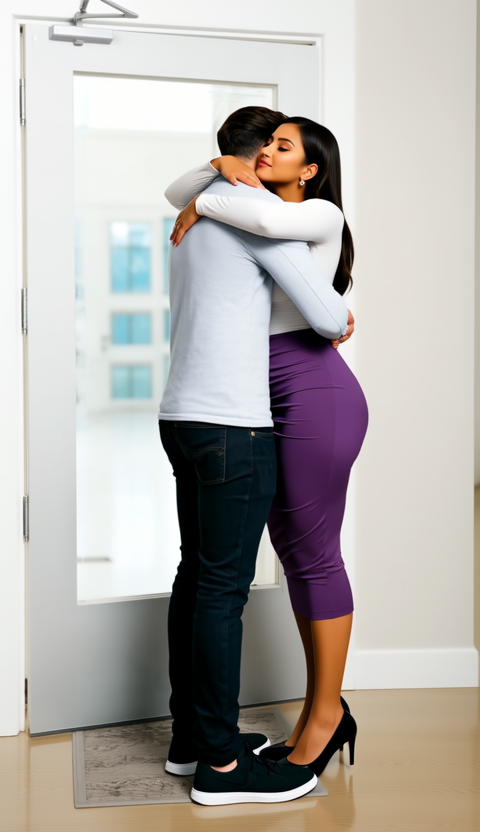

Prompt 5 is empty. Stopping generation loop.
Seed: 43
✅ Generation completed in 24 min 59.30 sec


In [4]:
# @title {"single-column":true}

# @markdown # 💥3. Generate Video


def mainSVI2Pro(
    offload_models: bool = True,
    image_path: str = None,
    prompt: list = [],
    widthI: int = 480,
    heightI: int = 832,
    seed: int = 43,
    frames: int = 81,
    fpsv: int = 25,
    show_last_frames: bool = True,
    show_all_videos: bool = True,
    use_sage_attention: bool = False,

    # Speed LoRAs
    use_high_noise_speed_LoRA: bool = True,
    high_noise_speed_LoRA_Strength: float = 1.00,
    use_low_noise_speed_LoRA: bool = True,
    low_noise_speed_LoRA_Strength: float = 1.00,
    # User LoRAs (High Noise / High Model)
    use_lora: bool = True,
    LoRA_Strength: float = 1.00,
    use_lora2: bool = False,
    LoRA_Strength2: float = 1.00,
    use_lora3: bool = False,
    LoRA_Strength3: float = 1.00,
    # User LoRAs (Low Noise / Low Model)
    use_lora1_lowNoise: bool = True,
    LoRA_Strength1_lowNoise: float = 1.00,
    use_lora2_lowNoise: bool = False,
    LoRA_Strength2_lowNoise: float = 1.00,
    use_lora3_lowNoise: bool = False,
    LoRA_Strength3_lowNoise: float = 1.00,
):
    import_custom_nodes()
    global global_vae
    global global_clip
    global global_high_unet
    global global_low_unet

    clear_output()

    with torch.inference_mode():

        loadimage = NODE_CLASS_MAPPINGS["LoadImage"]()
        loadimage_97 = loadimage.load_image(image=image_path)

        imageresizekjv2 = NODE_CLASS_MAPPINGS["ImageResizeKJv2"]()
        imageresizekjv2_136 = imageresizekjv2.resize(
            width=widthI,
            height=heightI,
            upscale_method="lanczos",
            keep_proportion="crop",
            pad_color="0, 0, 0",
            crop_position="center",
            divisible_by=2,
            device="cpu",
            image=get_value_at_index(loadimage_97, 0),
            unique_id=10235929917680962787,
        )


        ksamplerselect = NODE_CLASS_MAPPINGS["KSamplerSelect"]()
        ksamplerselect_out = ksamplerselect.EXECUTE_NORMALIZED(sampler_name="euler")

        randomnoise = NODE_CLASS_MAPPINGS["RandomNoise"]()
        disablenoise = NODE_CLASS_MAPPINGS["DisableNoise"]()
        modelsamplingsd3 = NODE_CLASS_MAPPINGS["ModelSamplingSD3"]()
        basicscheduler = NODE_CLASS_MAPPINGS["BasicScheduler"]()
        splitsigmas = NODE_CLASS_MAPPINGS["SplitSigmas"]()
        wanimagetovideosvipro = NODE_CLASS_MAPPINGS["WanImageToVideoSVIPro"]()
        scheduledcfgguidance = NODE_CLASS_MAPPINGS["ScheduledCFGGuidance"]()
        samplercustomadvanced = NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
        vaedecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
        createvideo = NODE_CLASS_MAPPINGS["CreateVideo"]()


        # print("Processing Anchor Image...")
        vaeloader = NODE_CLASS_MAPPINGS["VAELoader"]()
        vae_instance = vaeloader.load_vae(vae_name=vae_model)

        vaeencode = NODE_CLASS_MAPPINGS["VAEEncode"]()
        anchor_samples = vaeencode.encode(
            pixels=get_value_at_index(imageresizekjv2_136, 0),
            vae=get_value_at_index(vae_instance, 0),
        )



        if offload_models:
            # print("Offload Memory Mode: ON. Deleting VAE after anchor encoding.")
            del vae_instance
            del vaeloader
            clean_memory()
        else:
            print("Offload Memory Mode: OFF. Keeping models in memory.")
            if global_vae is None:
                global_vae = vae_instance

            if global_clip is None:
                print("Pre-loading CLIP...")
                cliploader = NODE_CLASS_MAPPINGS["CLIPLoader"]()
                global_clip = cliploader.load_clip(clip_name=clip_model, type="wan", device="default")

            if global_high_unet is None:
                print("Pre-loading High Model...")
                # unet_loader = NODE_CLASS_MAPPINGS["UnetLoaderGGUF"]()
                # global_high_unet = unet_loader.load_unet(unet_name=high_model)

                if high_model.lower().endswith(".safetensors"):
                    print(f"Loading Safetensors Model: {high_model}")
                    unet_loader = NODE_CLASS_MAPPINGS["DiffusionModelLoaderKJ"]()

                    # Set Sage Attention mode
                    sage_mode = "disabled"
                    if 'use_sage_attention' in locals() and use_sage_attention:
                        sage_mode = "auto"

                    global_high_unet = unet_loader.patch_and_load(
                        model_name=high_model,
                        weight_dtype="default",
                        compute_dtype="default",  # Fixed missing '=' here
                        patch_cublaslinear=False,
                        sage_attention=sage_mode,
                        enable_fp16_accumulation=False
                    )

                else:
                    print(f"Loading GGUF Model: {high_model}")
                    unet_loader = NODE_CLASS_MAPPINGS["UnetLoaderGGUF"]()
                    global_high_unet = unet_loader.load_unet(unet_name=high_model)

                if global_low_unet is None:
                    # print("Pre-loading Low Model...")
                    # global_low_unet = unet_loader.load_unet(unet_name=low_model)

                    if low_model.lower().endswith(".safetensors"):
                        print(f"Loading Safetensors Model: {low_model}")
                        unet_loader = NODE_CLASS_MAPPINGS["DiffusionModelLoaderKJ"]()

                        # Set Sage Attention mode
                        sage_mode = "disabled"
                        if use_sage_attention:
                            sage_mode = "auto"

                        global_low_unet = unet_loader.patch_and_load(
                            model_name=low_model,
                            weight_dtype="default",
                            compute_dtype="default",
                            patch_cublaslinear=False,
                            sage_attention=sage_mode,
                            enable_fp16_accumulation=False
                        )

                    else:
                        print(f"Loading GGUF Model: {low_model}")
                        unet_loader = NODE_CLASS_MAPPINGS["UnetLoaderGGUF"]()
                        global_low_unet = unet_loader.load_unet(unet_name=low_model)



        # --- Variables for Loop ---
        prev_samples = None
        accumulated_video_frames = None # Holds the pixel images for stitching

        # Iterate through prompts
        for i, current_prompt_text in enumerate(prompt):
            if not current_prompt_text or current_prompt_text.strip() == "":
                print(f"Prompt {i+1} is empty. Stopping generation loop.")
                break

            print(f"--- Generating Video Segment {i+1} ---")
            print(f"Prompt: {current_prompt_text}")

            # --- 1. CLIP Encoding ---
            current_clip = global_clip
            if offload_models:
                # print("Loading CLIP...")
                cliploader = NODE_CLASS_MAPPINGS["CLIPLoader"]()
                current_clip = cliploader.load_clip(clip_name=clip_model, type="wan", device="default")

            cliptextencode = NODE_CLASS_MAPPINGS["CLIPTextEncode"]()
            # Negative Embedding
            neg_embed = cliptextencode.encode(
                text="色调艳丽，过曝，静态，细节模糊不清，字幕，风格，作品，画作，画面，静止，整体发灰，最差质量，低质量，JPEG压缩残留，丑陋的，残缺的，多余的手指，画得不好的手部，画得不好的脸部，畸形的，毁容的，形态畸形的肢体，手指融合，静止不动的画面，杂乱的背景，三条腿，背景人很多，倒着走",
                clip=get_value_at_index(current_clip, 0),
            )
            # Positive Embedding
            pos_embed = cliptextencode.encode(
                text=current_prompt_text,
                clip=get_value_at_index(current_clip, 0),
            )

            if offload_models:
                # print("Unloading CLIP...")
                del current_clip
                del cliploader
                clean_memory()

            # --- 2. High Noise Pass (High Model) ---
            current_high_model = global_high_unet
            if offload_models:
                # print("Loading High Model...")
                # unet_loader = NODE_CLASS_MAPPINGS["UnetLoaderGGUF"]()
                # current_high_model = unet_loader.load_unet(unet_name=high_model)

                if high_model.lower().endswith(".safetensors"):
                    print(f"Loading Safetensors Model: {high_model}")
                    unet_loader = NODE_CLASS_MAPPINGS["DiffusionModelLoaderKJ"]()

                    # Set Sage Attention mode
                    sage_mode = "disabled"
                    if 'use_sage_attention' in locals() and use_sage_attention:
                        sage_mode = "auto"

                    current_high_model = unet_loader.patch_and_load(
                        model_name=high_model,
                        weight_dtype="default",
                        compute_dtype="default",  # Fixed missing '=' here
                        patch_cublaslinear=False,
                        sage_attention=sage_mode,
                        enable_fp16_accumulation=False
                    )

                else:
                    print(f"Loading GGUF Model: {high_model}")
                    unet_loader = NODE_CLASS_MAPPINGS["UnetLoaderGGUF"]()
                    current_high_model = unet_loader.load_unet(unet_name=high_model)





            # Apply LoRAs to High Model
            # Start with the base model
            active_high_model = get_value_at_index(current_high_model, 0)

            pathch_sage_attention = PathchSageAttentionKJ()

            if use_sage_attention and high_model.lower().endswith(".gguf"):
                active_high_model = pathch_sage_attention.patch(active_high_model, "auto")[0]

            loraloader = NODE_CLASS_MAPPINGS["LoraLoaderModelOnly"]()

            # Speed LoRA High
            if use_high_noise_speed_LoRA:
                # print("Applying High Speed LoRA...")
                active_high_model = get_value_at_index(loraloader.load_lora_model_only(
                    lora_name=high_speed_lora,
                    strength_model=high_noise_speed_LoRA_Strength,
                    model=active_high_model
                ), 0)

            # User LoRA 1 (High)
            if use_lora and lora_1 is not None:
                # print("Applying User LoRA 1 (High)...")
                active_high_model = get_value_at_index(loraloader.load_lora_model_only(
                    lora_name=lora_1,
                    strength_model=LoRA_Strength,
                    model=active_high_model
                ), 0)

            # User LoRA 2 (High)
            if use_lora2 and lora_2 is not None:
                # print("Applying User LoRA 2 (High)...")
                active_high_model = get_value_at_index(loraloader.load_lora_model_only(
                    lora_name=lora_2,
                    strength_model=LoRA_Strength2,
                    model=active_high_model
                ), 0)

            if use_lora3 and lora_3 is not None:
                #  print("Applying User LoRA 3 (High)...")
                 active_high_model = get_value_at_index(loraloader.load_lora_model_only(
                    lora_name=lora_3,
                    strength_model=LoRA_Strength3,
                    model=active_high_model
                ), 0)

            # Model Sampling Setup (High)
            modelsamplingsd3_high = modelsamplingsd3.patch(
                shift=5.0,
                model=active_high_model,
            )

            basicscheduler_high = basicscheduler.EXECUTE_NORMALIZED(
                scheduler="simple", steps=6, denoise=1,
                model=get_value_at_index(modelsamplingsd3_high, 0)
            )

            splitsigmas_high = splitsigmas.EXECUTE_NORMALIZED(
                step=3, sigmas=get_value_at_index(basicscheduler_high, 0)
            )

            # WAN Image to Video Setup
            # For first frame (i==0), motion_latent_count might be 0 or handled differently?
            # Based on source, if prev_samples exists, we use it.

            # If i == 0, we don't have prev_samples, use standard logic
            # If i > 0, we pass prev_samples

            # Determine motion_latent_count based on context (User code used 0 for first, 1 for second)
            m_latent_count = 1 if i > 0 else 0

            wan_args = {
                "length": frames,
                "motion_latent_count": m_latent_count,
                "positive": get_value_at_index(pos_embed, 0),
                "negative": get_value_at_index(neg_embed, 0),
                "anchor_samples": get_value_at_index(anchor_samples, 0)
            }
            if i > 0 and prev_samples is not None:
                wan_args["prev_samples"] = prev_samples

            wan_video_node = wanimagetovideosvipro.EXECUTE_NORMALIZED(**wan_args)

            # Guiders and Sampler (High)
            scheduledcfgguidance_high = scheduledcfgguidance.get_guider(
                cfg=1, start_percent=0, end_percent=1,
                model=active_high_model,
                positive=get_value_at_index(wan_video_node, 0),
                negative=get_value_at_index(wan_video_node, 1),
            )

            noise_seed = seed + (i * 100) # Variation per prompt
            randomnoise_node = randomnoise.EXECUTE_NORMALIZED(noise_seed=noise_seed)

            # Sample Pass 1
            clear_output()
            print(f"Prompt: {current_prompt_text}")
            print("Sampling (High Model)...")
            sampler_high_out = samplercustomadvanced.EXECUTE_NORMALIZED(
                noise=get_value_at_index(randomnoise_node, 0),
                guider=get_value_at_index(scheduledcfgguidance_high, 0),
                sampler=get_value_at_index(ksamplerselect_out, 0),
                sigmas=get_value_at_index(splitsigmas_high, 0),
                latent_image=get_value_at_index(wan_video_node, 2),
            )

            if offload_models:
                # print("Unloading High Model...")
                del active_high_model
                del current_high_model
                del modelsamplingsd3_high
                del scheduledcfgguidance_high
                clean_memory()

            # --- 3. Low Noise Pass (Low Model) ---
            current_low_model = global_low_unet
            if offload_models:
                # print("Loading Low Model...")
                # unet_loader = NODE_CLASS_MAPPINGS["UnetLoaderGGUF"]()
                # current_low_model = unet_loader.load_unet(unet_name=low_model)

                if low_model.lower().endswith(".safetensors"):
                    print(f"Loading Safetensors Model: {low_model}")
                    unet_loader = NODE_CLASS_MAPPINGS["DiffusionModelLoaderKJ"]()

                    # Set Sage Attention mode
                    sage_mode = "disabled"
                    if use_sage_attention:
                        sage_mode = "auto"

                    current_low_model = unet_loader.patch_and_load(
                        model_name=low_model,
                        weight_dtype="default",
                        compute_dtype="default",
                        patch_cublaslinear=False,
                        sage_attention=sage_mode,
                        enable_fp16_accumulation=False
                    )

                else:
                    print(f"Loading GGUF Model: {low_model}")
                    unet_loader = NODE_CLASS_MAPPINGS["UnetLoaderGGUF"]()
                    current_low_model = unet_loader.load_unet(unet_name=low_model)

            # Apply LoRAs to Low Model
            active_low_model = get_value_at_index(current_low_model, 0)

            if use_sage_attention and low_model.lower().endswith(".gguf"):
                active_low_model = pathch_sage_attention.patch(active_low_model, "auto")[0]

            # Speed LoRA Low
            if use_low_noise_speed_LoRA:
                # print("Applying Low Speed LoRA...")
                active_low_model = get_value_at_index(loraloader.load_lora_model_only(
                    lora_name=low_speed_lora,
                    strength_model=low_noise_speed_LoRA_Strength,
                    model=active_low_model
                ), 0)

            # User LoRA 1 (Low)
            if use_lora1_lowNoise and lora_1_lowNoise is not None:
                # print("Applying User LoRA 1 (Low)...")
                active_low_model = get_value_at_index(loraloader.load_lora_model_only(
                    lora_name=lora_1_lowNoise,
                    strength_model=LoRA_Strength1_lowNoise,
                    model=active_low_model
                ), 0)

            # User LoRA 2 (Low)
            if use_lora2_lowNoise and lora_2_lowNoise is not None:
                # print("Applying User LoRA 2 (Low)...")
                active_low_model = get_value_at_index(loraloader.load_lora_model_only(
                    lora_name=lora_2_lowNoise,
                    strength_model=LoRA_Strength2_lowNoise,
                    model=active_low_model
                ), 0)

            # User LoRA 3 (Low)
            if use_lora3_lowNoise and lora_3_lowNoise is not None:
                # print("Applying User LoRA 3 (Low)...")
                active_low_model = get_value_at_index(loraloader.load_lora_model_only(
                    lora_name=lora_3_lowNoise,
                    strength_model=LoRA_Strength3_lowNoise,
                    model=active_low_model
                ), 0)

            # Guiders and Sampler (Low)
            scheduledcfgguidance_low = scheduledcfgguidance.get_guider(
                cfg=1, start_percent=0, end_percent=1,
                model=active_low_model,
                positive=get_value_at_index(wan_video_node, 0),
                negative=get_value_at_index(wan_video_node, 1),
            )

            disablenoise_node = disablenoise.EXECUTE_NORMALIZED()

            # Sample Pass 2
            clear_output()
            print(f"Prompt: {current_prompt_text}")
            print("Sampling (Low Model)...")
            sampler_low_out = samplercustomadvanced.EXECUTE_NORMALIZED(
                noise=get_value_at_index(disablenoise_node, 0),
                guider=get_value_at_index(scheduledcfgguidance_low, 0),
                sampler=get_value_at_index(ksamplerselect_out, 0),
                sigmas=get_value_at_index(splitsigmas_high, 1), # Using index 1 of sigmas from previous step logic
                latent_image=get_value_at_index(sampler_high_out, 0),
            )

            # Store latents for next iteration
            prev_samples = get_value_at_index(sampler_low_out, 0)

            if offload_models:
                # print("Unloading Low Model...")
                del active_low_model
                del current_low_model
                del scheduledcfgguidance_low
                clean_memory()

            # --- 4. VAE Decode ---
            current_vae = global_vae
            if offload_models:
                # print("Loading VAE...")
                vaeloader = NODE_CLASS_MAPPINGS["VAELoader"]()
                current_vae = vaeloader.load_vae(vae_name=vae_model)

            clear_output()
            print(f"Prompt: {current_prompt_text}")
            print("Decoding Latents to Video...")
            decoded_images = vaedecode.decode(
                samples=prev_samples,
                vae=get_value_at_index(current_vae, 0),
            )

            if offload_models:
                # print("Unloading VAE...")
                del current_vae
                del vaeloader
                clean_memory()

            # --- 5. Stitching and Display ---
            current_video_pixels = get_value_at_index(decoded_images, 0)

            if accumulated_video_frames is None:
                accumulated_video_frames = current_video_pixels
            else:
                print("Stitching video segments...")
                imagebatchextendwithoverlap = NODE_CLASS_MAPPINGS["ImageBatchExtendWithOverlap"]()
                extended_batch = imagebatchextendwithoverlap.imagesfrombatch(
                    overlap=5,
                    overlap_side="source",
                    overlap_mode="linear_blend",
                    source_images=accumulated_video_frames,
                    new_images=current_video_pixels,
                )
                accumulated_video_frames = get_value_at_index(extended_batch, 2)

            # Display logic
            # If show_all_videos is True, we create and show the video up to this point
            if show_all_videos or (i == len(prompt) - 1) or (prompt[i+1].strip() == ""):
                print(f"Rendering video output for Stage {i+1}...")
                video_obj = createvideo.EXECUTE_NORMALIZED(
                    fps=fpsv,
                    images=accumulated_video_frames
                )

                # Retrieve the raw object usually wrapped in a tuple
                video_data = get_value_at_index(video_obj, 0)

                # Save and Display
                global output_path
                output_path = save_video_from_components(video_data, filename_prefix=f"video/SVI_Seg_{i}")
                display_video(output_path)

                if show_last_frames:
                    last_frame_path = save_as_image(current_video_pixels[-1], f"image_{i}")
                    display(IPImage(filename=last_frame_path))
                    pass



import time
start_time = time.time()
# @markdown ### Video Settings
image_file_1 = file_uploaded

prompt1 = "The camera moves back to track the lady as she walks fast towards the door." # @param {"type":"string"}
prompt2 = "The camera tracks the lady as she opens the door and walks into the street." # @param {"type":"string"}
prompt3 = "The camera tracks the lady as she walked towards a man who also walked towards her." # @param {"type":"string"}
prompt4 = "The lady and the man hug each other." # @param {"type":"string"}
prompt5 = "" # @param {"type":"string"}
prompt6 = "" # @param {"type":"string"}
prompt7 = "" # @param {"type":"string"}
prompt8 = "" # @param {"type":"string"}
prompt9 = "" # @param {"type":"string"}
prompt10 = "" # @param {"type":"string"}
prompt11 = "" # @param {"type":"string"}
prompt12 = "" # @param {"type":"string"}

prompt = [prompt1,prompt2,prompt3,prompt4,prompt5,prompt6,prompt7,prompt8,prompt9,prompt10,prompt11,prompt12]


width = 480 # @param {"type":"number"}
height = 832 # @param {"type":"number"}
seed = 43 # @param {"type":"integer"}
frames = 81 # @param {"type":"integer", "min":1, "max":1200}
fps = 15 # @param {"type":"integer", "min":1, "max":60}

show_all_videos = True # @param {type:"boolean"}
show_last_frames = True # @param {type:"boolean"}

use_sage_attention = True # @param {type:"boolean"}

# @markdown ### Speed LoRA Configuration
use_high_noise_speed_LoRA = True # @param {type:"boolean"}
high_noise_speed_LoRA_Strength = 1 # @param {"type":"slider","min":-10,"max":10,"step":0.01}

use_low_noise_speed_LoRA = True # @param {type:"boolean"}
low_noise_speed_LoRA_Strength = 1 # @param {"type":"slider","min":-10,"max":10,"step":0.01}



# @markdown ### LoRA Configuration
use_lora1_for_highNoise = True # @param {type:"boolean"}
LoRA_Strength1_highNoise = 1.0 # @param {"type":"slider","min":-100,"max":100,"step":0.01}
use_lora1_for_lowNoise = True # @param {type:"boolean"}
LoRA_Strength1_lowNoise = 1.0 # @param {"type":"slider","min":-100,"max":100,"step":0.01}
use_lora2_for_highNoise = False # @param {type:"boolean"}
LoRA_Strength2_highNoise = 1.0 # @param {"type":"slider","min":-100,"max":100,"step":0.01}
use_lora2_for_lowNoise = False # @param {type:"boolean"}
LoRA_Strength2_lowNoise = 1.0 # @param {"type":"slider","min":-100,"max":100,"step":0.01}
use_lora3_for_highNoise = False # @param {type:"boolean"}
LoRA_Strength3_highNoise = 1.0 # @param {"type":"slider","min":-100,"max":100,"step":0.01}
use_lora3_for_lowNoise = False # @param {type:"boolean"}
LoRA_Strength3_lowNoise = 1.0 # @param {"type":"slider","min":-100,"max":100,"step":0.01}


import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")



mainSVI2Pro(
    offload_models=offload_models_for_lowMemory,
    image_path=image_file_1,
    prompt=prompt,
    widthI=width,
    heightI=height,
    seed=seed,
    frames=frames,
    fpsv=fps,
    show_last_frames=show_last_frames,
    show_all_videos=show_all_videos,
    use_sage_attention=use_sage_attention,
    use_high_noise_speed_LoRA=use_high_noise_speed_LoRA,
    high_noise_speed_LoRA_Strength=high_noise_speed_LoRA_Strength,
    use_low_noise_speed_LoRA=use_low_noise_speed_LoRA,
    low_noise_speed_LoRA_Strength=low_noise_speed_LoRA_Strength,
    use_lora=use_lora1_for_highNoise,
    LoRA_Strength=LoRA_Strength1_highNoise,
    use_lora1_lowNoise=use_lora1_for_lowNoise,
    LoRA_Strength1_lowNoise=LoRA_Strength1_lowNoise,
    use_lora2=use_lora2_for_highNoise,
    LoRA_Strength2=LoRA_Strength2_highNoise,
    use_lora2_lowNoise=use_lora2_for_lowNoise,
    LoRA_Strength2_lowNoise=LoRA_Strength2_lowNoise,
    use_lora3=use_lora3_for_highNoise,
    LoRA_Strength3=LoRA_Strength3_highNoise,
    use_lora3_lowNoise=use_lora3_for_lowNoise,
    LoRA_Strength3_lowNoise=LoRA_Strength3_lowNoise,
)






end_time = time.time()
duration = end_time - start_time
mins, secs = divmod(duration, 60)
print(f"Seed: {seed}")
# print(f"prompt: {positive_prompt}")
print(f"✅ Generation completed in {int(mins)} min {secs:.2f} sec")

clear_memory()

In [ ]:
# @title {"single-column":true}

# @markdown # 💥4. Apply Frame Interpolation


import glob
from IPython.display import Video as outVid
import time
start_time = time.time()

FRAME_MULTIPLIER = 2 # @param {"type":"number"}
vid_fps = 30 # @param {"type":"number"}
crf_value = 17 # @param {"type":"slider","min":0,"max":51,"step":1}

print(f"Converting video to {vid_fps} fps...")

%cd /content/Practical-RIFE

# Suppress ALSA errors
os.environ["XDG_RUNTIME_DIR"] = "/tmp"
os.environ["SDL_AUDIODRIVER"] = "dummy"

# Disable warnings from ffmpeg about missing audio
os.environ["PYGAME_HIDE_SUPPORT_PROMPT"] = "1"
os.environ["FFMPEG_LOGLEVEL"] = "quiet"

!python3 inference_video.py --multi={FRAME_MULTIPLIER} --fps={vid_fps} --video={output_path} --scale={1}
video_folder = "/content/ComfyUI/output/"

# Find the latest MP4 file
video_files = glob.glob(os.path.join(video_folder, "*.mp4"))

if video_files:
    latest_video = max(video_files, key=os.path.getctime)
    # !ffmpeg -i "{latest_video}" -vcodec libx264 -crf 18 -preset fast output_converted.mp4 -loglevel error -y
    !ffmpeg -i "{latest_video}" -vcodec libx264 -crf {crf_value} -preset fast output_converted.mp4 -loglevel error -y

    print(f"Displaying video: {latest_video}")
    # display(outVid("output_converted.mp4", embed=True))
    display_video("output_converted.mp4")
    # displayVid(outVid(latest_video, embed=True))
else:
    print("❌ No video found in output/")

del video_files

end_time = time.time()
duration = end_time - start_time
mins, secs = divmod(duration, 60)
print(f"✅ Frame Interpolation completed in {int(mins)} min {secs:.2f} sec")

clear_memory()

%cd /content/ComfyUI

# @markdown ---